In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from collections import defaultdict
import seaborn as sns
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader

In [ ]:
!unzip dolphin_postprocces_dataset_0_45.zip

Archive:  dolphin_postprocces_dataset_0_45.zip
  inflating: dolphin_postprocces_dataset/test/0/1899_DSC_3672.JPG  
  inflating: dolphin_postprocces_dataset/test/0/1123_DSC_1495.JPG  
  inflating: dolphin_postprocces_dataset/test/0/1619_DSC_0488.JPG  
  inflating: dolphin_postprocces_dataset/test/0/2442_DSC_3697.JPG  
  inflating: dolphin_postprocces_dataset/test/0/1567_DSC_3611.JPG  
  inflating: dolphin_postprocces_dataset/test/0/3480_DSC_3653.JPG  
  inflating: dolphin_postprocces_dataset/test/0/1421_DSC_3767.JPG  
replace dolphin_postprocces_dataset/test/0/14_DSC_0566.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip dolphin_postprocces_dataset_full_0_45.zip

In [8]:
!cp /content/dolphin_postprocces_dataset/val/1/108_DSC_1613.JPG /content/dolphin_postprocces_dataset/test/1/108_DSC_1613.JPG

In [9]:
import os

print('Train dataset:', len(os.listdir('dolphin_postprocces_dataset/train/1')) +
      len(os.listdir('dolphin_postprocces_dataset/train/0')))
print('Train dolphins:', len(os.listdir('dolphin_postprocces_dataset/train/1')))
print('Train not dolphins:', len(os.listdir('dolphin_postprocces_dataset/train/0')))
print()
print('Val dataset:', len(os.listdir('dolphin_postprocces_dataset/val/1')) +
      len(os.listdir('dolphin_postprocces_dataset/val/0')))
print('Val dolphins:', len(os.listdir('dolphin_postprocces_dataset/val/1')))
print('Val not dolphins:', len(os.listdir('dolphin_postprocces_dataset/val/0')))
print()
print('Test dataset:', len(os.listdir('dolphin_postprocces_dataset/test/1')) +
      len(os.listdir('dolphin_postprocces_dataset/test/0')))
print('Test dolphins:', len(os.listdir('dolphin_postprocces_dataset/test/1')))
print('Test not dolphins:', len(os.listdir('dolphin_postprocces_dataset/test/0')))

Train dataset: 228
Train dolphins: 220
Train not dolphins: 8

Val dataset: 80
Val dolphins: 77
Val not dolphins: 3

Test dataset: 178
Test dolphins: 1
Test not dolphins: 177


In [10]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("./")
image_path = data_path / "dolphin_postprocces_dataset"

In [11]:
data_transform_resize = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

class ResNetPad():
    def __call__(self, image, shape=(224, 224)):
        y_, x_ = shape
        y, x = image.size[1], image.size[0]
        y_pad = (y_-y)
        x_pad = (x_-x)
        return np.pad(image, ((y_pad//2, y_pad//2 + y_pad%2),
                         (x_pad//2, x_pad//2 + x_pad%2),
                         (0, 0)),
                      mode = 'constant')

data_transform_padding = transforms.Compose([
    ResNetPad(),
    transforms.ToTensor()
])

In [12]:
from torchvision import datasets

train_data_resize = datasets.ImageFolder(root=image_path / "train",
                                  transform=data_transform_resize)

train_data_padding = datasets.ImageFolder(root=image_path / "train",
                                  transform=data_transform_padding)

val_data_resize = datasets.ImageFolder(root=image_path / "val",
                                  transform=data_transform_resize)

val_data_padding = datasets.ImageFolder(root=image_path / "val",
                                  transform=data_transform_padding)

test_data_resize = datasets.ImageFolder(root=image_path / "test",
                                  transform=data_transform_resize)

test_data_padding = datasets.ImageFolder(root=image_path / "test",
                                  transform=data_transform_padding)

print(f"Data:\n{train_data_resize}")
print(f"Data:\n{train_data_padding}")

print(f"Data:\n{val_data_resize}")
print(f"Data:\n{val_data_padding}")

print(f"Data:\n{test_data_resize}")
print(f"Data:\n{test_data_padding}")

Data:
Dataset ImageFolder
    Number of datapoints: 228
    Root location: dolphin_postprocces_dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Data:
Dataset ImageFolder
    Number of datapoints: 228
    Root location: dolphin_postprocces_dataset/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Data:
Dataset ImageFolder
    Number of datapoints: 80
    Root location: dolphin_postprocces_dataset/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Data:
Dataset ImageFolder
    Number of datapoints: 80
    Root location: dolphin_postprocces_dataset/val
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Data:
Dataset ImageFolder
    Number of datapoints: 178
  

In [13]:
data_resize = datasets.ImageFolder(root=data_path / "dolphin_postprocces_dataset_full",
                                  transform=data_transform_resize)

data_padding = datasets.ImageFolder(root=data_path / "dolphin_postprocces_dataset_full",
                                  transform=data_transform_padding)

In [14]:
from torch.utils.data import DataLoader

train_dataloader_resize = DataLoader(train_data_resize, batch_size=32, shuffle=True)
test_dataloader_resize = DataLoader(test_data_resize, batch_size=1, shuffle=False)
val_dataloader_resize = DataLoader(val_data_resize, batch_size=1, shuffle=True)

train_dataloader_padding = DataLoader(train_data_padding, batch_size=32, shuffle=True)
test_dataloader_padding = DataLoader(test_data_padding, batch_size=1, shuffle=False)
val_dataloader_padding = DataLoader(val_data_padding, batch_size=1, shuffle=True)

In [15]:
dataloader_resize = DataLoader(data_resize, batch_size=1, shuffle=False)
dataloader_padding = DataLoader(data_padding, batch_size=1, shuffle=False)

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Модель

In [22]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights)

In [23]:
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Обучение

## Функции

In [24]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    criterion = nn.CrossEntropyLoss()

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            outputs = model(data)
            loss = criterion(outputs, target)

        loss_log.append(loss.item())

        predicted = torch.argmax(outputs, dim=1)
        acc = (predicted == target).sum() / data.shape[0]

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        predicted = torch.argmax(outputs, dim=1)
        acc = (predicted == target).sum() / data.shape[0]

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [25]:
def draw_model_plot(acc, val_acc, loss, val_loss):

    epoch_range = range(len(acc))

    plt.plot(epoch_range, acc, label='Training accuracy')
    plt.plot(epoch_range, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epoch_range, loss, label='Training loss')
    plt.plot(epoch_range, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    plt.show()

In [26]:
def make_preds(model, loader):
    model.eval()
    preds = []

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            outputs = model(data)

        predicted = torch.argmax(outputs, dim=1)
        preds.append(predicted.item())

    return np.array(preds)

## ResNet50 + resize

In [27]:
optimizer = optim.AdamW(resnet50.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet50, optimizer, 30,
                                                                 train_dataloader_resize,
                                                                 val_dataloader_resize)

Epoch 0
 train loss: 2.3883979467791505, train acc: 0.71875
 val loss: 1.288979890942566, val acc: 0.9625

Epoch 1
 train loss: 0.20319261762779206, train acc: 0.96484375
 val loss: 0.14453473930770996, val acc: 0.9625

Epoch 2
 train loss: 0.10436461470089853, train acc: 0.96875
 val loss: 0.16376338743939414, val acc: 0.9625

Epoch 3
 train loss: 0.10718638601247221, train acc: 0.96875
 val loss: 0.16812244533621196, val acc: 0.9625

Epoch 4
 train loss: 0.08763944351812825, train acc: 0.96875
 val loss: 0.19819720459220774, val acc: 0.9625

Epoch 5
 train loss: 0.09576460998505354, train acc: 0.96875
 val loss: 0.10634726695020902, val acc: 0.9625

Epoch 6
 train loss: 0.0707833943888545, train acc: 0.97265625
 val loss: 0.224738091747259, val acc: 0.9625

Epoch 7
 train loss: 0.09337878099177033, train acc: 0.953125
 val loss: 0.16164706483541522, val acc: 0.95

Epoch 8
 train loss: 0.051985634258016944, train acc: 0.98046875
 val loss: 0.2577221014441761, val acc: 0.9375

Epoch 9


In [ ]:
epoch_num = 30
batch_size = 32
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

270 30 30


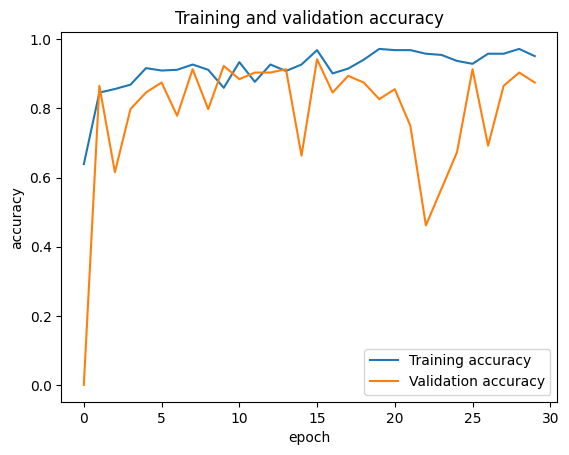

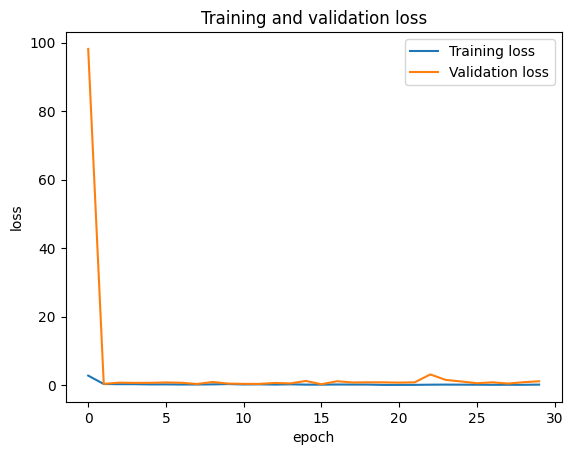

In [ ]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [ ]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights)
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
optimizer = optim.AdamW(resnet50.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet50, optimizer, 12,
                                                                 train_dataloader_resize,
                                                                 val_dataloader_resize)

Epoch 0
 train loss: 2.7612687150637307, train acc: 0.6430555582046509
 val loss: 41.12117936724658, val acc: 0.09615384615384616

Epoch 1
 train loss: 0.3707270208332274, train acc: 0.8541666666666666
 val loss: 0.460368182237569, val acc: 0.9038461538461539

Epoch 2
 train loss: 0.33746325804127586, train acc: 0.8597222235467699
 val loss: 1.1692677672522573, val acc: 0.22115384615384615

Epoch 3
 train loss: 0.30362391223510105, train acc: 0.8819444444444444
 val loss: 0.543586754208753, val acc: 0.7115384615384616

Epoch 4
 train loss: 0.2278082991639773, train acc: 0.8923611111111112
 val loss: 0.4835049327845739, val acc: 0.8173076923076923

Epoch 5
 train loss: 0.32992736001809436, train acc: 0.8687500026490953
 val loss: 0.9507884514521237, val acc: 0.8653846153846154

Epoch 6
 train loss: 0.3393343538045883, train acc: 0.877083334657881
 val loss: 0.9707233373899651, val acc: 0.8942307692307693

Epoch 7
 train loss: 0.3827052017052968, train acc: 0.8548611137602065
 val loss: 

In [ ]:
epoch_num = 12
batch_size = 32
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

108 12 12


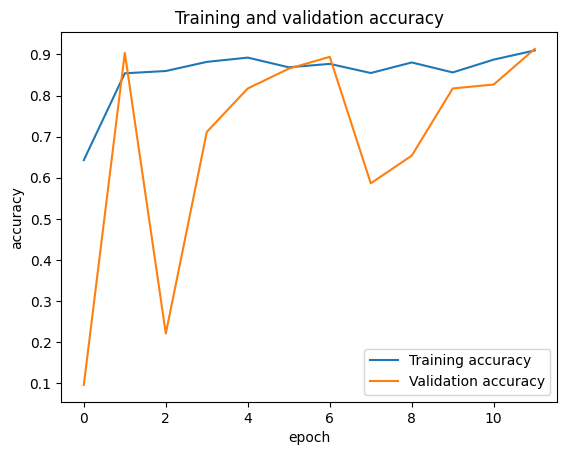

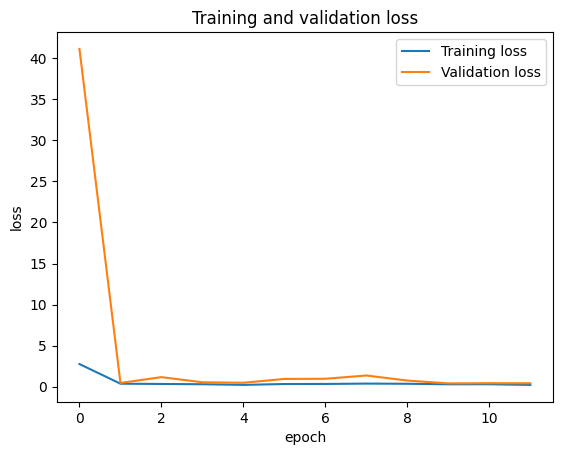

In [ ]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [ ]:
test_loss, test_acc = test(resnet50, test_dataloader_resize)
test_loss, test_acc

(2.2020802387018663, 0.3096120583148011)

In [ ]:
from sklearn.metrics import classification_report

preds = make_preds(resnet50, test_dataloader_resize)

labels = []
for _, label in test_dataloader_resize:
    labels.append(label)
labels = np.array(labels)

print('Test dataset')
print(classification_report(preds, labels))

preds = make_preds(resnet50, dataloader_resize)

print(preds)

labels = []
for _, label in dataloader_resize:
    labels.append(label)
labels = np.array(labels)

print('All dataset')
print(classification_report(preds, labels))

Test dataset
              precision    recall  f1-score   support

           0       0.31      1.00      0.47      1252
           1       1.00      0.00      0.00      2795

    accuracy                           0.31      4047
   macro avg       0.65      0.50      0.24      4047
weighted avg       0.79      0.31      0.15      4047

[1 1 1 ... 1 1 1]
All dataset
              precision    recall  f1-score   support

           0       0.31      0.99      0.47      1261
           1       0.97      0.08      0.15      3150
           2       0.00      0.00      0.00         0

    accuracy                           0.34      4411
   macro avg       0.43      0.36      0.21      4411
weighted avg       0.78      0.34      0.24      4411



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(len(preds))

4411


In [ ]:
torch.save(resnet50.state_dict(), 'resnet50_resize.pth')